In [1]:
!pip install kaggle


In [2]:
!mkdir -p ~/.kaggle

In [3]:
!cp kaggle.json ~/.kaggle/

In [4]:
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d vipoooool/new-plant-diseases-dataset

Dataset URL: https://www.kaggle.com/datasets/vipoooool/new-plant-diseases-dataset
License(s): copyright-authors
100% 2.69G/2.70G [00:30<00:00, 126MB/s]
100% 2.70G/2.70G [00:31<00:00, 93.4MB/s]


In [6]:
!unzip new-plant-diseases-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid/Strawberry___healthy/273a7a9e-18be-4b6a-976a-fa5ffd69b731___RS_HL 4366_90deg.JPG  
  inflating: new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid/Strawberry___healthy/275f8963-f4f4-4903-962b-1da716725d08___RS_HL 4780_90deg.JPG  
  inflating: new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid/Strawberry___healthy/275f8963-f4f4-4903-962b-1da716725d08___RS_HL 4780_new30degFlipLR.JPG  
  inflating: new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid/Strawberry___healthy/27c2aaa4-de4b-4fb1-ba8d-14d4b24b2afa___RS_HL 4665.JPG  
  inflating: new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid/Strawberry___healthy/27c2aaa4-de4b-4fb1-ba8d-14d4b24b2afa___RS_HL 4665_270deg.JPG  
  inflating: new plant diseases dataset(augmented)/New 

In [7]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping


In [8]:
train_dir = '/content/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train'
valid_dir = '/content/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid'


In [9]:
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

valid_datagen = ImageDataGenerator(rescale=1.0/255)


In [10]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)


Found 70295 images belonging to 38 classes.


In [11]:
valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)


Found 17572 images belonging to 38 classes.


In [12]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(train_generator.num_classes, activation='softmax')
])


In [13]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [14]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


In [16]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=valid_generator,
    validation_steps=valid_generator.samples // valid_generator.batch_size,
    epochs=2,
    callbacks=[early_stopping]
)


Epoch 1/2
2196/2196 [==============================] - 4925s 2s/step - loss: 1.0171 - accuracy: 0.6883 - val_loss: 0.6112 - val_accuracy: 0.8066
Epoch 2/2
2196/2196 [==============================] - 4895s 2s/step - loss: 0.5019 - accuracy: 0.8417 - val_loss: 0.5269 - val_accuracy: 0.8403


In [17]:
test_loss, test_accuracy = model.evaluate(valid_generator, steps=valid_generator.samples // valid_generator.batch_size)
print(f'Validation Accuracy: {test_accuracy * 100:.2f}%')


549/549 [==============================] - 294s 535ms/step - loss: 0.5270 - accuracy: 0.8403
Validation Accuracy: 84.03%


550/550 [==============================] - 294s 534ms/step - loss: 0.5269 - accuracy: 0.8403
Validation Loss: 0.5268635749816895
Validation Accuracy: 84.03%
550/550 [==============================] - 290s 527ms/step
Accuracy: 2.59%
Precision: 2.57%
Recall: 2.59%
F1 Score: 2.54%
                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.04      0.04      0.04       504
                                 Apple___Black_rot       0.03      0.05      0.04       497
                          Apple___Cedar_apple_rust       0.01      0.01      0.01       440
                                   Apple___healthy       0.02      0.02      0.02       502
                               Blueberry___healthy       0.02      0.02      0.02       454
          Cherry_(including_sour)___Powdery_mildew       0.02      0.02      0.02       421
                 Cherry_(including_sour)___healthy       0.03      0.02     

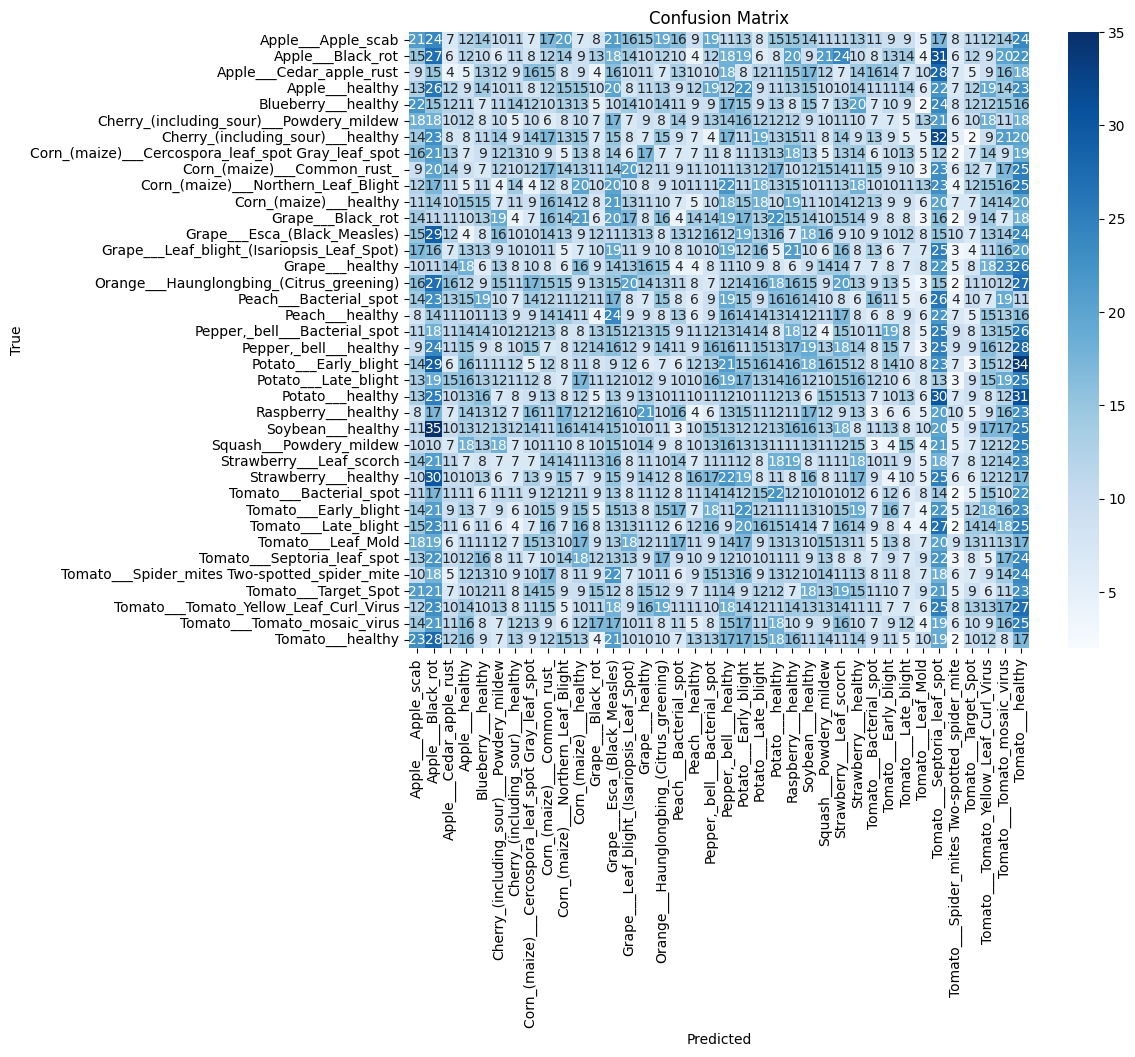

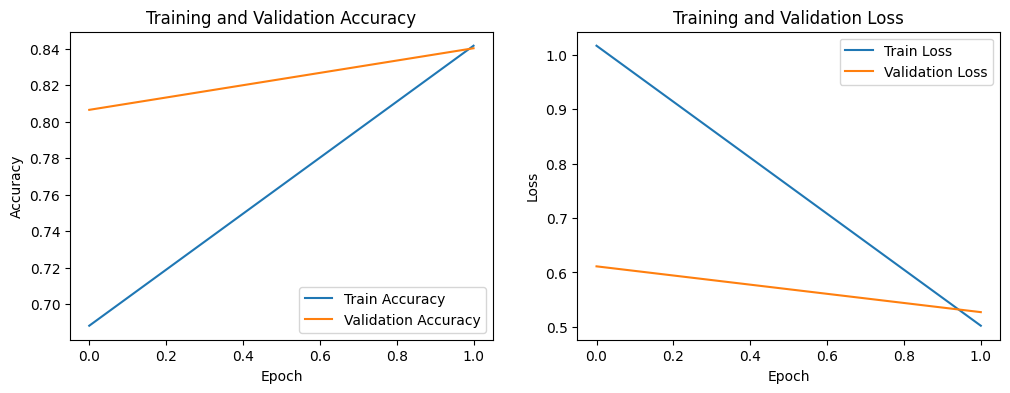

In [19]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

# Evaluate the model on the validation set
validation_loss, validation_accuracy = model.evaluate(valid_generator)
print(f'Validation Loss: {validation_loss}')
print(f'Validation Accuracy: {validation_accuracy * 100:.2f}%')

# Predict the classes for the validation set
predictions = model.predict(valid_generator)
predicted_classes = np.argmax(predictions, axis=1)

# Get the true labels for the validation set
true_labels = valid_generator.classes
class_labels = list(valid_generator.class_indices.keys())

# Calculate additional metrics
accuracy = accuracy_score(true_labels, predicted_classes)
precision = precision_score(true_labels, predicted_classes, average='weighted')
recall = recall_score(true_labels, predicted_classes, average='weighted')
f1 = f1_score(true_labels, predicted_classes, average='weighted')

print(f'Accuracy: {accuracy * 100:.2f}%')
print(f'Precision: {precision * 100:.2f}%')
print(f'Recall: {recall * 100:.2f}%')
print(f'F1 Score: {f1 * 100:.2f}%')

# Generate the classification report
report = classification_report(true_labels, predicted_classes, target_names=class_labels)
print(report)

# Generate the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_classes)
print(conf_matrix)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Plot the training and validation accuracy and loss
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()
